In [2]:
# Autor: Daniel Pinto
# Caminos de Costo minimo, Grafo de precedencia y orden topologico
# Fecha: 2021/12/06 YYYY/MM/DD
from typing import List, TypeVar, Tuple, Any, Callable, Optional, Generic, Dict
from hypothesis import given, strategies as st
from IPython.display import Markdown, display
from dataclasses import dataclass, field
from __future__ import annotations 
from copy import deepcopy
from collections.abc import  Iterable
import graphviz as gv
from abc import ABCMeta, abstractmethod
from math import inf

def display_(s : str) -> None:
    '''
    A way to display strings with markdown 
    in jupyter.
    '''
    display(
        Markdown(s)
    )


SUCCESS_COLOR = '#4BB543'
ERROR_COLOR   = '#B00020'

def color_text(s : str, color : str =SUCCESS_COLOR ) -> str:
    return f"<span style='color:{color}'> {s} </span>."


a      = TypeVar('a')
b      = TypeVar('b')
c      = TypeVar('c')
T      = TypeVar('T')

In [3]:
class AGraph(Generic[T], metaclass=ABCMeta):
    @abstractmethod
    def add_vertex(self,v : T) -> None:
        raise NotImplementedError

    @abstractmethod
    def add_edge(self,vs : Tuple[T,T]) -> None:
        raise NotImplementedError

    
    def add_vertices(self, vertices : Iterable[T]) -> None:
        for vertex in vertices:
            self.add_vertex(vertex)

    
    def add_edges(self, edges : Iterable[Tuple[T,T]]) -> None:
        for edge in edges:
            self.add_edge(edge)

    @abstractmethod
    def succs(self, v : T) -> List[T]:
        raise NotImplementedError

    @abstractmethod
    def preds(self, v : T) -> List[T]:
        raise NotImplementedError
    
    @abstractmethod
    def get_randV(self) -> T:
        raise NotImplementedError

    @abstractmethod
    def get_Vertices(self) -> set[T]:
        raise NotImplementedError

    @abstractmethod
    def get_Edges(self) -> set[Tuple[T,T]]:
        raise NotImplementedError

    
    def BFS_levels(self, iv : Optional[T] = None) -> Iterable[List[T]]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True



        while bool(mem) and change:
            change = False
            yield current
            for v in current:
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    def BFS(self, iv : Optional[T] = None) -> Iterable[T]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True

        while bool(mem) and change:
            change = False
            for v in current:
                yield v
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    
    def DFS(self, iv : Optional[T] = None) -> Iterable[T]:

        if iv is None:
            try:
                iv  = self.get_randV()
            except:
                return


        mem : set[T] = self.get_Vertices()
        def DFS_(v : T) -> Iterable[T] :
            mem.discard(v)
            yield v
            if not mem:
                return

            for succ in self.succs(v):
                # si el sucesor aun no se ha visitado
                if succ in mem:
                    for s in DFS_(succ):
                        yield s

        return DFS_(iv)

    
    def toPic(self) -> gv.Graph:
        raise NotImplementedError


@dataclass
class Graph(Generic[T],AGraph[T]):
    _Map         : Dict[T,int]   
    _adj_l       : List[List[T]]
    _i           : int 
    _is_directed : bool
    _is_weighted : bool
    _invMap      : Dict[int,T]
    _cost        : Dict[Tuple[T,T],float]

    def __init__(self, is_directed : bool = False, is_weighted : bool = False) -> None:
        self._Map         = {}
        self._invMap      = {}
        self._adj_l       = []
        self._i           = 0
        self._cost        = {}
        self._is_directed = is_directed
        self._is_weighted = is_weighted

    def get_cost(self,vw : Tuple[T,T]) -> Optional[float]:
        if vw not in self._cost:
            return None
        return self._cost[vw]
    
    def add_vertex(self,v : T) -> None:
        if v in self._Map:
            return
        
        self._Map[v] = self._i
        self._adj_l.append([])
        self._invMap[self._i] = v
        self._i    += 1
    
    def _add_edge_dir(self, vs: Tuple[T, T]) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        
        # a -> [a,b,c]

        i : int = self._Map[v]
        if s not in self._adj_l[i]:
            self._adj_l[i].append(s)
    
    def _add_edge_undir(self, vs: Tuple[T, T]) -> None:
        sv = (vs[1],vs[0])
        # (v,s)
        # (s,v)
        self._add_edge_dir(vs)
        self._add_edge_dir(sv)
    
    def _add_edge_cost_dir(self, vs: Tuple[T, T], cost : float) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        i : int = self._Map[v]
        if s in self._adj_l[i]:
            self._cost[vs] = cost
    
    def _add_edge_cost_undir(self, vs: Tuple[T, T], cost : float) -> None:
        sv = (vs[1],vs[0])
        self._add_edge_cost_dir(vs, cost)
        self._add_edge_cost_dir(sv, cost)


    def add_edge(self,vs : Tuple[T,T], cost : float = 0) -> None:
        if self._is_directed:
            self._add_edge_dir(vs)
        else:
            self._add_edge_undir(vs)
        
        if self._is_weighted:
            self._add_edge_cost_dir(vs,cost)
        else:
            self._add_edge_cost_undir(vs,cost)

    def add_cost_edges(self, edges : Iterable[Tuple[T,T,float]]) -> None:
        for (v,s,c) in edges:
            self.add_edge((v,s),c)
            if not self._is_directed:
                self.add_edge((s,v),c)


    def succs(self, v : T) -> List[T]:
        i : int = self._Map[v]
        return self._adj_l[i]
    
    def preds(self, v : T) -> List[T]:
        # 
        if not self._is_directed:
            return self.succs(v)
        
        res : List[T] = []
        for i in range(self._i):
            if v in self._adj_l[i]:
                res.append(self._invMap[i])
        return res

    def get_Vertices(self) -> set[T]:
        return set(self._Map.keys())
    
    def get_Edges(self) -> set[Tuple[T, T]]:
        s : set[Tuple[T, T]] = set()
        for v in self.get_Vertices():
            for v_ in self._adj_l[self._Map[v]]:
                if ((v_,v) in s) and (not self._is_directed):
                    pass
                else:
                    s.add((v,v_))

        return s

    def get_randV(self) -> T:
        from random import randint
        try:
            n : int = randint(0,len(self._adj_l)-1)
        except:
            raise ValueError
        
        return self._invMap[n]


    def _toPicDir(self) -> gv.Graph:
        g : gv.Graph = gv.Digraph()
        if not self._Map:
            return g

        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)

        return g
    
    def _toPicUnDir(self) -> gv.Graph:
        g : gv.Graph = gv.Graph()
        if not self._Map:
            return g
        
        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)
        
        return g

    def toPic(self) -> gv.Graph:
        if self._is_directed:
            return self._toPicDir()
        else:
            return self._toPicUnDir()
    
    def __deepcopy__(self) -> Graph[T]:
        g : Graph[T]   = Graph()
        g._Map         = deepcopy(self._Map)
        g._adj_l       = deepcopy(self._adj_l)
        g._i           = deepcopy(self._i)
        g._is_directed = deepcopy(self._is_directed)
        g._is_weighted = deepcopy(self._is_weighted)
        g._invMap      = deepcopy(self._invMap)
        g._cost        = deepcopy(self._cost)

        return g






In [4]:
@dataclass
class Heap(Generic[T,a]):
    arr         : List[Tuple[a,T]]  
    assocs      : Dict[T,List[int]] 
    is_max_heap : bool          
    lt          : Callable[[a,a],bool]   
    gt          : Callable[[a,a],bool]   

    def __init__(self, is_max_heap : bool) -> None:
        self.arr         = []
        self.assocs      = {}
        self.is_max_heap = is_max_heap
        self.lt          = (lambda x,y: x<y ) if is_max_heap else (lambda x,y: x>y )
        self.gt          = (lambda x,y: x>y ) if is_max_heap else (lambda x,y: x<y )


    def up_heapify(self, i : int):
        p : int = (i-1) // 2
        while(True):
            if (p<0) or self.gt(self.arr[p][0], self.arr[i][0]):
                return
            
            # p : 3
            # p_val : [0,3,5]
            p_val   : T   = self.arr[p][1]
            i_val   : T   = self.arr[i][1]
            p_index : int = self.assocs[p_val].index(p)
            i_index : int = self.assocs[i_val].index(i)

            self.assocs[p_val][p_index] = i
            self.assocs[i_val][i_index] = p
            
            self.arr[p], self.arr[i] = self.arr[i], self.arr[p]

            i = p
            p = (p-1) // 2

    def down_heapify(self,i : int):
        l : int = (2*i) + 1
        r : int = (2*i) + 2
        largest : int = -1
        n : int = len(self.arr) - 1
        
        if l>n and r>n:
            return
        if r>n:
            r=l
        if l>n:
            l=r

        if self.gt(self.arr[i][0], self.arr[l][0] ) and self.gt(self.arr[i][0], self.arr[r][0]):
            return


        if self.gt(self.arr[l][0], self.arr[r][0]):
            largest = l
        else:
            largest = r
        

        largest_val   : T   = self.arr[largest][1]
        i_val         : T   = self.arr[i][1]
        largest_index : int = self.assocs[largest_val].index(largest)
        i_index : int = self.assocs[i_val].index(i)

        self.assocs[largest_val][largest_index] = i
        self.assocs[i_val][i_index] = largest

        self.arr[largest], self.arr[i] = self.arr[i], self.arr[largest]

        self.down_heapify(largest)

    def extract_root_(self) -> Optional[T]:
        if self.arr == []:
            return None
        
        root : T = self.arr[0][1]
        self.arr[0], self.arr[-1] = self.arr[-1], self.arr[0]

        new_root : T = self.arr[0][1]
        n : int = len(self.arr) - 1
        n_index : int = self.assocs[new_root].index(n) 
        self.assocs[new_root][n_index] = 0 


        self.arr.pop()

        self.down_heapify(0)
        
        return root
        


    def insert_(self, x:T, priority : a):
        self.arr.append((priority,x))
        n : int = len(self.arr) - 1
        if x in self.assocs:
            self.assocs[x].append(n)
        else:
            self.assocs[x] = [n]

        self.up_heapify(n)



    def push_pop(self,x : T, priority : a) -> T:
        if self.arr == []:
            return x
        if self.gt(priority,  self.arr[0][0]):
            return x
        root : T = self.arr[0][1]
        if self.assocs[root] == []:
            self.assocs.pop(root)
        else:
            self.assocs[root].remove(0)
        if x in self.assocs:
            self.assocs[x].append(0)
        else:
            self.assocs[x] = [0]
        self.arr[0] = (priority,x)
        self.down_heapify(0) 

        return root

    def modify_val(self, x:T, priority : a, f : Callable[[T,a,a],a] = lambda val,new,old: new):
        if x not in self.assocs:
            return
        pos_x = self.assocs[x][0]

        (p,v) = self.arr[pos_x]
        p_    = f(x,priority,p)

        self.arr[pos_x] = (p_,v)
        
        self.down_heapify(pos_x)
        self.up_heapify(pos_x)

    def toPic(self) -> gv.Digraph:
        dot : gv.Digraph = gv.Digraph(comment='Heap')
        current : int = 0
        if self.arr == []:
            return dot
        dot.node(str(0),str(self.arr[0]))
        for i in range(1,len(self.arr)):
            dot.node(str(i),str(self.arr[i]))
            dot.edge(str((i-1)//2),str(i))
        return dot 

def randomHeap(size : int = 10 ) -> Heap[int,int]:
    from random import randint
    acc  : List[int] = []
    heap : Heap[int,int] = Heap(is_max_heap=False) 
    for _ in range(size):
        n = randint(-size,size)
        acc.append(n)
        heap.insert_(n,n)
    
    print(acc)
    return heap




h : Heap[int,int] = randomHeap()        
#h.toPic().view(filename="name.gv",cleanup=True,)
#print(h.extract_root())
print(h.assocs)
print(h.arr)
h.toPic()



@dataclass(order=True)
class PrioritizedItem(Generic[T]):
    priority: float
    item: Any= field(compare=False)

    def __eq__(self, o: object) -> bool:
        if not isinstance(o,PrioritizedItem):
            return False
        
        return self.item == o.item

    def __hash__(self) -> int:
        return self.item.__hash__()


t1 = PrioritizedItem(1,'a') 
t2 = PrioritizedItem(2,'b')
d = {}
d[t1] = 10
d[t2] = 20

print(d[PrioritizedItem(10,'a')])



[-3, -4, 2, 8, 2, 8, -9, 10, -1, 4]
{-3: [1], -4: [2], 2: [6, 4], 8: [8, 5], -9: [0], 10: [7], -1: [3], 4: [9]}
[(-9, -9), (-3, -3), (-4, -4), (-1, -1), (2, 2), (8, 8), (2, 2), (10, 10), (8, 8), (4, 4)]
10


# Exercise: Word Search

Given an `m x n` grid of characters board and a string `word`, return `true` if `word` exists in the grid.

The word can be constructed from letters of sequentially adjacent cells, where adjacent cells are horizontally or vertically neighboring. The same letter cell may not be used more than once.

## Examples:

<center>

![''](./Images/word1.jpg)

</center>

```
Input: 
    board = [["A","B","C","E"],["S","F","C","S"],["A","D","E","E"]]
    word  = "ABCCED"
    word  = "EEEEEEE"
Output: true
```


<center>

![''](./Images/word2.jpg)

</center>

```
Input: 
    board = [["A","B","C","E"],["S","F","C","S"],["A","D","E","E"]]
    word  = "SEE"
Output: true
```


<center>

![''](./Images/word3.jpg)

</center>

```
Input: 
    board = [["A","B","C","E"],["S","F","C","S"],["A","D","E","E"]]
    word  = "ABCB"
Output: true
```


In [5]:
#sol

# Exercise:  Trust groups

The personnel department of Association of Cookie Monsters (ACM) has noticed
that the productivity of various work groups in the company is not as good as it
could be. 

They have interviewed the employees in the affected groups and they
have detected the root of the problem: trust (or, rather, the lack thereof).

Some employees do not trust the rest of the group, and this is decreasing their motivation
and happiness. The personnel department wants to solve this problem, and has
decided to reorganize the groups so that they are stable, i.e., they are formed by
people who trust each other. 

They have asked the employees, and they know the people each employee trusts directly. Moreover, 
if employee A trusts employee B and employee B trusts employee C, then employee A will trust employee C. And
obviously, each employee trusts himself.

They want to create as few groups as
possible to reduce administration overhead (they also do not want to work too
hard).

With this information they have contacted you, and asked you to write a
program that nds the minimum number of stable groups that can be created.


In [6]:
#
# Personas = [1,2,3,4]
# Confia : Dict[int,List[int]] = 
#    {
#        1 : [1,3]
#        3 : [3,4,1]
#        4 : [4,2,1]
#        2 : [2]
#    }

# Solucion: 2
# porque los grupos son: [3,4,1] [2]

# Componente fuertemente Conexo
# Strongly connected component (SCC)

# Camino mas Corto: Defininicion

Sea $P=<v_0,\dots,v_n>$ es un camino de coto minimo de $v_0$ a $v_n$ si y solo si $Costo(P)=cmin(v_0,v_n)$ en donde:


$$
cmin(v_0,v_n) = 
\begin{cases}
min\{Costo(P): P = <v_0,\dots,v_n> \} && \text{Si existe al menos un camino } P \text{ de } v_0 \text{ a } v_n \\
\infty && \text{De otra forma}
\end{cases}
$$


# Camino mas Corto: Principio De Optimalidad:

Sea $G=(V,E)$ un grafo, y $P=<v_0,\dots,v_n>$. Si $Costo(P)=cmin(v_0,v_n)$ entonces cualquier subcamino $P_{ij}=<v_i,\dots,v_j>$ con $0 \leq i \leq j \leq n$ cumple: $Costo(P_{ij})=cmin(v_i,v_j)$

# Camino mas Corto: dijkstra

Sea $G$ un grafo **sin costos negativos**, y $s,t$ dos vertices del grafo, el algoritmo de Dijkstra encuentra el camino de costo minimo entre $s$ y $t$ de la siguiente forma.




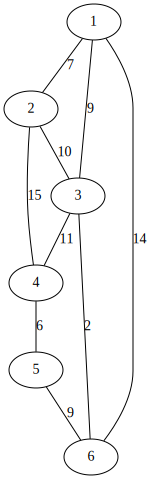

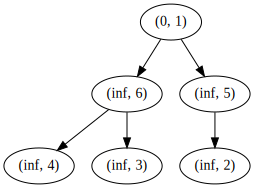

[1, 3, 6, 5]


In [7]:

def dijkstra(G : Graph[T], s : T, t : T) -> List[T]:
    res = []
    vs : set[T] = G.get_Vertices()
    c : Dict[T,float]         = {}
    
    p : Dict[T,Optional[T]]   = {}
    queue : Heap[T,float]     = Heap(is_max_heap=False)


    for v in vs:
        c[v] = inf
        queue.insert_(v,inf)
        p[v] = None
    
    c[s]  = 0
    queue.modify_val(s,0)
    display(queue.toPic())

    while (w := queue.extract_root_()) is not None:
        for v in G.succs(w):
            vw_cost = G.get_cost((w,v))
            if (vw_cost is not None) and (c[v] > c[w] + vw_cost):
                c[v] = c[w] + vw_cost
                p[v] = w
                queue.modify_val(v,c[v])

    res = [t]
    while (a := p[t]) is not None:
        res.insert(0,a)
        t = a

    return res 

g : Graph[int] = Graph(is_directed=False, is_weighted=True)

g.add_vertices([1,2,3,4,5,6])
g.add_cost_edges([(1,2,7),(1,3,9),(1,6,14),(2,3,10),(2,4,15),(6,5,9),(6,3,2),(3,4,11),(4,5,6)])


display(g.toPic())

print(dijkstra(g,1,5))

# 

# A*

`A*` is just spicy dijkstra...


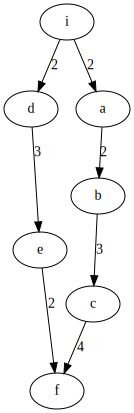

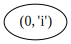

['i', 'd', 'e', 'f']


In [8]:
# consistencia : h(v) = h(v) <= (v,u) + h(u)
# admisibles   : h(v) <= h*(v) = cmin(v,t)



#                       t
#                       |
#                       |
#                       |
#                       |
#                       |
#                       |
#   s-------------------

# 1 2 3
# 4 _ 6
# 7 8 5

# Hamming distance

# La distancia euclidiana: sqrt((x-x_t)^2  + (y-y_t)^2)
# La distancia manhattan: abs(x-x_t) + abs(y-y_t)


def A_star(G : Graph[T], s : T, t : T, h : Callable[[T],float] = lambda _: 0, is_consistent: bool = True) -> List[T]:

    res = []
    vs : set[T] = G.get_Vertices()
    c : Dict[T,float]         = {}
    p : Dict[T,Optional[T]]   = {}
    queue : Heap[T,float]     = Heap(is_max_heap=False)
    visited : set[T]          = set()
    for v in vs:
        c[v] = inf
        p[v] = None
    c[s]  = 0 #+ h(s)
    queue.insert_(s,0)
    #queue.modify_val(s,0)
    display(queue.toPic())


    # 
    while (w := queue.extract_root_()) is not None:
        if is_consistent:
            visited.add(w)
        if w == t:
            break
        for v in G.succs(w):
            vw_cost = G.get_cost((w,v))
            assert(vw_cost is not None)
            # not (is_consistent and v in visitados)
            if (not is_consistent) or (v not in visited):
                c[v] = c[w] + vw_cost + h(v)
                p[v] = w
                queue.insert_(v,c[v])

    res = [t]
    while (a := p[t]) is not None:
        res.insert(0,a)
        t = a

    return res 

    
g : Graph[str] = Graph(is_directed=True, is_weighted=True)

g.add_vertices('iabcdef')
g.add_cost_edges([('i','a',2),('i','d',2),('a','b',2),('d','e',3),('b','c',3),('e','f',2),('c','f',4)])

def h(v : str) -> float:
    h_ : Dict[str,float] = {}
    h_['a'] = 4
    h_['b'] = 2
    h_['c'] = 4
    h_['d'] = 5
    h_['e'] = 2
    h_['f'] = 0

    return h_[v]


display(g.toPic())

print(A_star(g,'i','f',h))

# Precedence Graphs And Topological Order

Sea $G$ un grafo dirigido (digrafo),y $f : V \rightarrow \mathbb{N}$ una funcion inyectiva, $f$ es un orden topologico si $\forall \ (v,u) \in \pi_e(G)$, entonces $f(v) < f(u)$





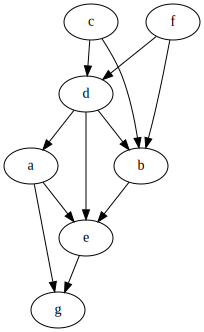

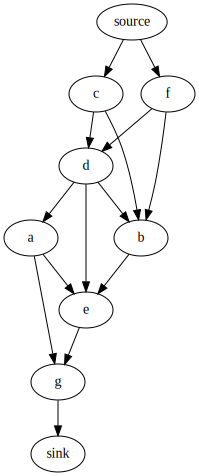

['source', 'f', 'c', 'd', 'b', 'a', 'e', 'g', 'sink']


In [12]:
g : Graph[str] = Graph(is_directed=True)
g.add_vertices(['a','b','c','d','e','f','g'])#,"fuente","sumidero"])
'''
a:5
e:6
b:4
f:1
c:2
d:3
g:7
'''
g.add_edges([('a','e'),('a','g'),('e','g'),('d','a'),
    ('d','e'),('d','b'),('b','e'),('c','d'),('c','b')
    ,('f','d'),('f','b')])#,("fuente",'f'),("fuente",'c'),('g',"sumidero") ])


display(g.toPic())


# Basicamente dijkstra con extra steps
def orden_topologico(G_ : Graph[T]) -> List[T | str]:

    source_vertices : set[T] = G_.get_Vertices()
    sink_vertices   : set[T] = G_.get_Vertices()
    has_succ        : bool   = False

    vs : set[T] = G_.get_Vertices()
    c : Dict[T | str,float]         = {}
    queue : Heap[T | str,float]     = Heap(is_max_heap=False)


    for v in vs:
        c[v] = 0
    
    for v in vs:
        has_succ = False
        for succ in G_.succs(v):
            has_succ = True 
            source_vertices.discard(succ)
            c[succ] += 1
        if has_succ:
            sink_vertices.discard(v)

    # Un valor T para cualquier tipo T
    # Grafo[T] <= Graph[T | str]
    G : Graph[T | str] = G_.__deepcopy__()
    G.add_vertices(["source","sink"])
    c["source"] = 0
    c["sink"]   = 0
    for source in source_vertices:
        c[source] = 1
        G.add_edge(("source",source))
    
    for sink in sink_vertices:
        G.add_edge((sink,"sink"))
        c["sink"]   += 1



    for v in vs:
        queue.insert_(v,c[v])

    queue.insert_("source",c["source"])
    queue.insert_("sink",c["sink"])

    #display(queue.toPic())

    display(G.toPic())
    topos_order : List[T | str] = []

    while (w := queue.extract_root_()) is not None:
        topos_order.append(w)
        for v in G.succs(w):
            c[v] = c[v] - 1
            queue.modify_val(v,c[v])


    return topos_order

print(orden_topologico(g))

#val(label)= val(label') => label == label'
# Grafo de precedencia es un grafo que representa una RELACION DE ORDEN ESTRICTO sobre los vertices

In [10]:
def precedence_graph(G : Graph[T]):
    return